# Imports

In [83]:
from __future__ import annotations
import itertools
import joblib
import warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, PowerTransformer
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from skopt.searchcv import BayesSearchCV

warnings.simplefilter(action="ignore", category=UserWarning)
warnings.simplefilter(action="ignore", category=FutureWarning)

%matplotlib inline
pd.options.display.max_columns = None
plt.style.use("ggplot")

In [6]:
df: pd.DataFrame = pd.read_csv('wine-quality.csv')

# Data Preparation

## Check for duplicate rows

In [7]:
df.shape

(6497, 13)

In [8]:
df.duplicated().sum()

1177

In [9]:
df = df.drop_duplicates()
df.shape

(5320, 13)

## Change spaces in column names to underscores

In [10]:
df.columns = df.columns.str.replace(' ', '_')


## Check for missing values

In [11]:
df.isna().sum()

type                    0
fixed_acidity           0
volatile_acidity        0
citric_acid             0
residual_sugar          0
chlorides               0
free_sulfur_dioxide     0
total_sulfur_dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

# Exploratory Data Analysis

## Basic information about the dataset

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5320 entries, 0 to 6496
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   type                  5320 non-null   object 
 1   fixed_acidity         5320 non-null   float64
 2   volatile_acidity      5320 non-null   float64
 3   citric_acid           5320 non-null   float64
 4   residual_sugar        5320 non-null   float64
 5   chlorides             5320 non-null   float64
 6   free_sulfur_dioxide   5320 non-null   float64
 7   total_sulfur_dioxide  5320 non-null   float64
 8   density               5320 non-null   float64
 9   pH                    5320 non-null   float64
 10  sulphates             5320 non-null   float64
 11  alcohol               5320 non-null   float64
 12  quality               5320 non-null   int64  
dtypes: float64(11), int64(1), object(1)
memory usage: 581.9+ KB


In [13]:
df.describe()

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality
count,5320.000000,5320.000000,5320.000000,5320.000000,5320.000000,5320.000000,5320.000000,5320.000000,5320.000000,5320.000000,5320.000000,5320.000000
mean,7.215179,0.344130,0.318494,5.048477,0.056690,30.036654,114.109023,0.994535,3.224664,0.533357,10.549241,5.795677
std,1.319671,0.168248,0.147157,4.500180,0.036863,17.805045,56.774223,0.002966,0.160379,0.149743,1.185933,0.879772
min,3.800000,0.080000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.400000,0.230000,0.240000,1.800000,0.038000,16.000000,74.000000,0.992200,3.110000,0.430000,9.500000,5.000000
50%,7.000000,0.300000,0.310000,2.700000,0.047000,28.000000,116.000000,0.994650,3.210000,0.510000,10.400000,6.000000
75%,7.700000,0.410000,0.400000,7.500000,0.066000,41.000000,153.250000,0.996770,3.330000,0.600000,11.400000,6.000000
max,15.900000,1.580000,1.660000,65.800000,0.611000,289.000000,440.000000,1.038980,4.010000,2.000000,14.900000,9.000000


In [14]:
df.describe(include="object")

,type
count,5320
unique,2
top,white
freq,3961


In [15]:
numeric_features: list[str] = list(df.select_dtypes(exclude="object").drop(columns=["quality"]).columns)
categorical_features: list[str] = list(df.select_dtypes(include="object").columns)

<hr />

## Distribution of each feature

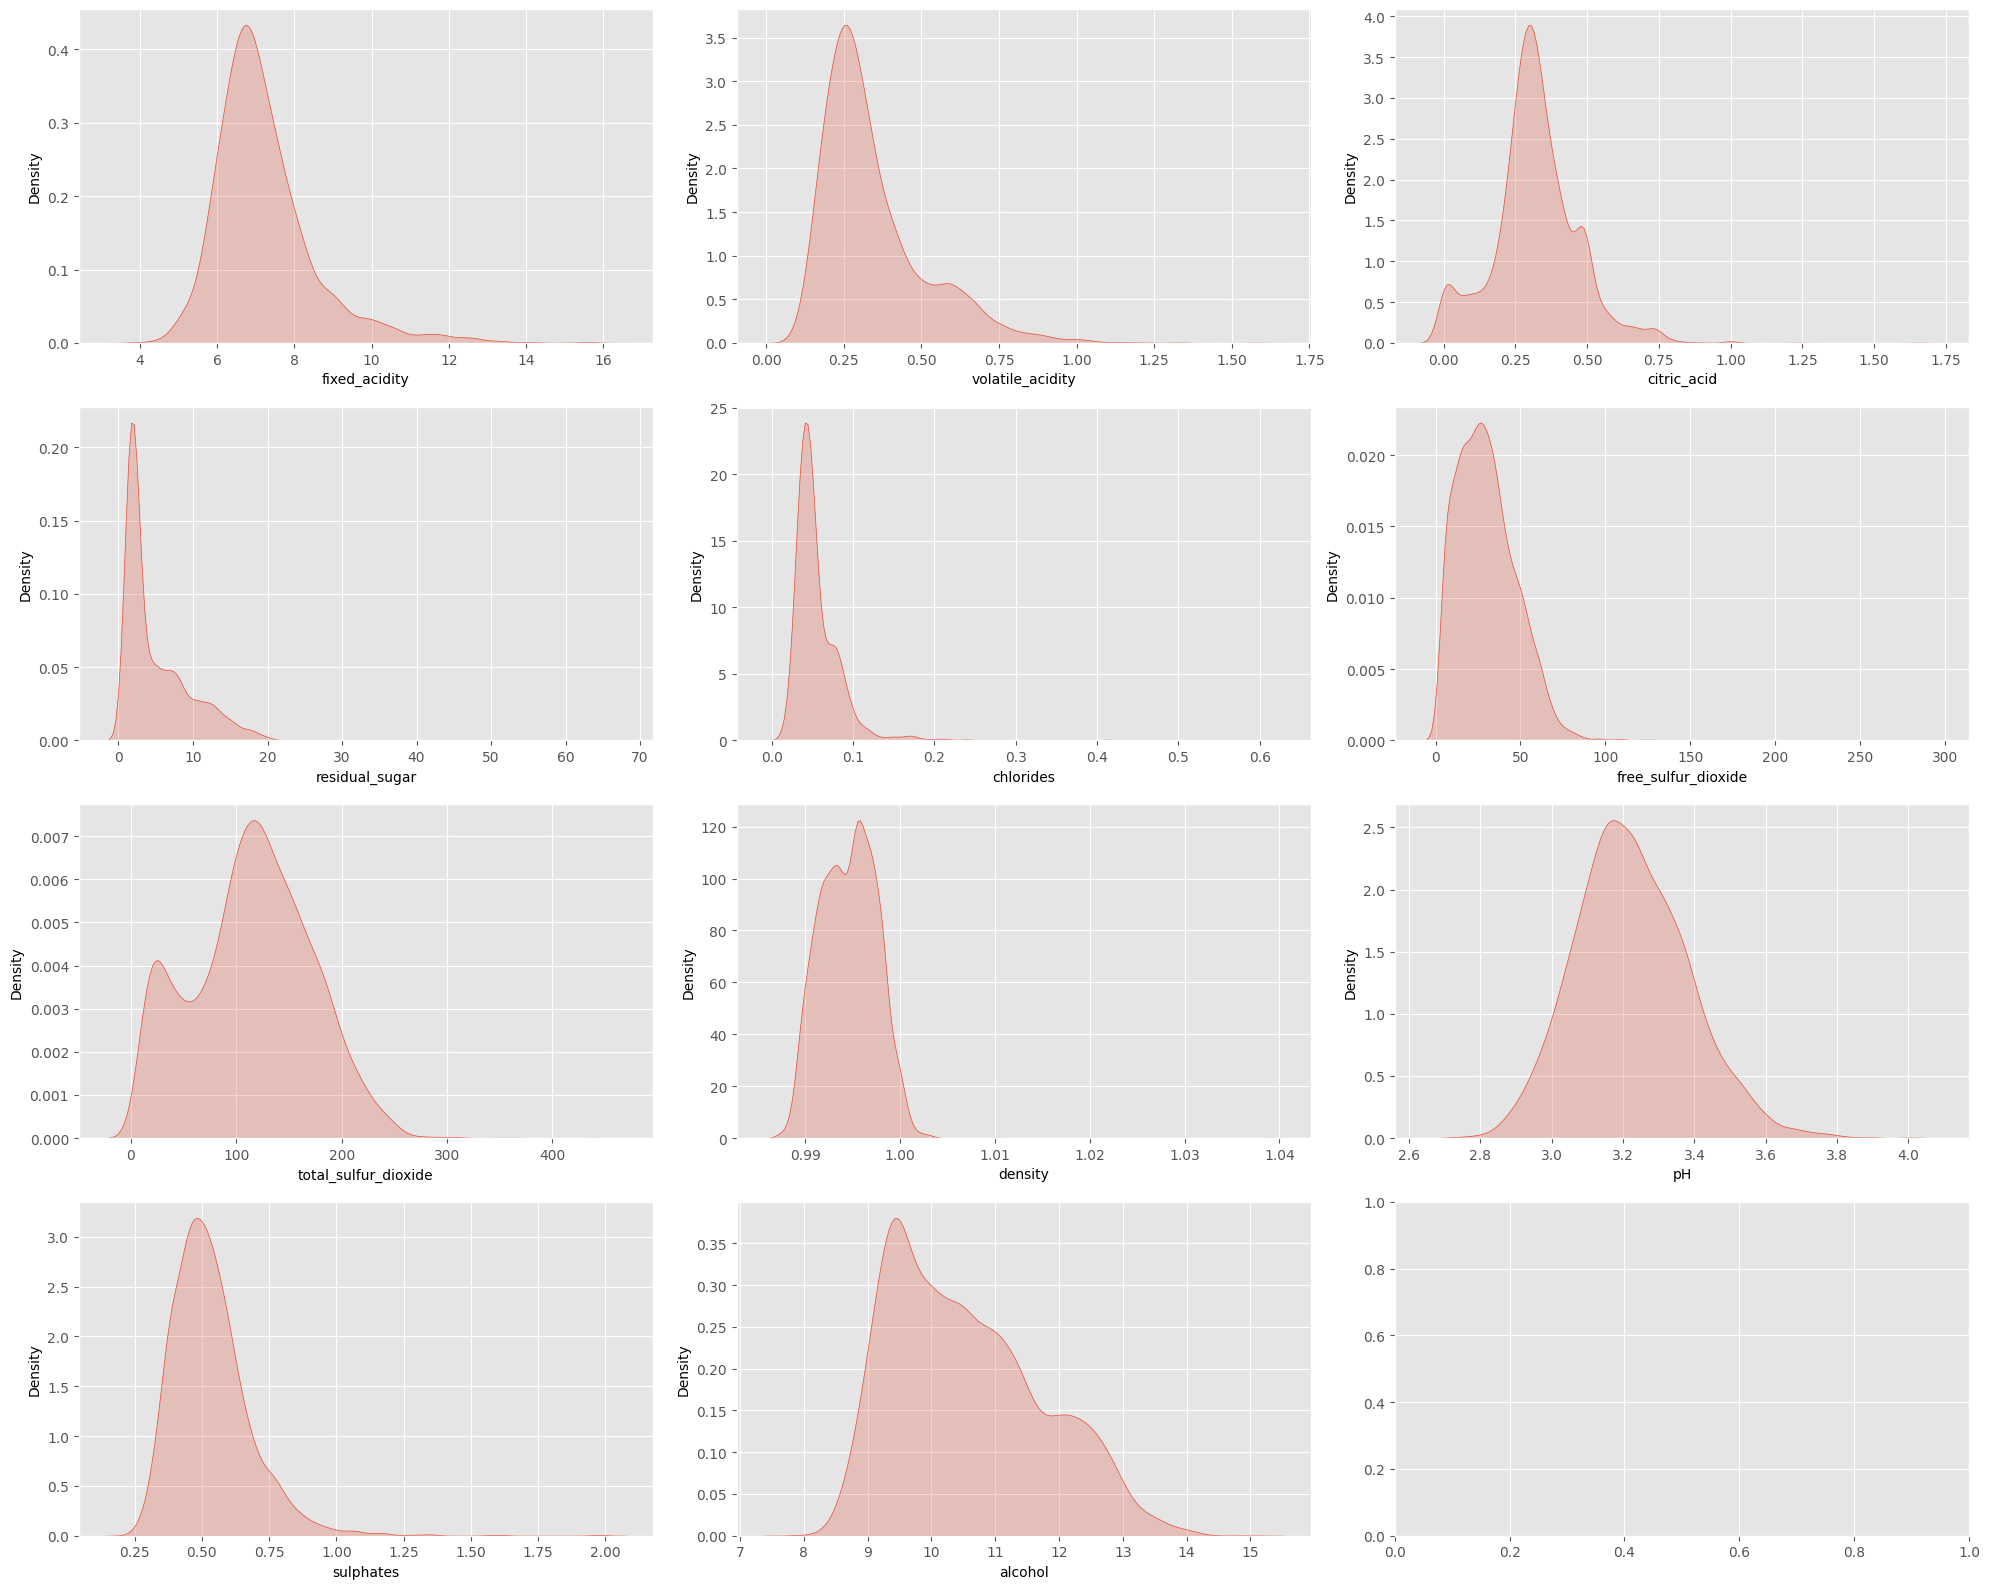

In [16]:
fig, axes = plt.subplots(4, 3, figsize=(20, 16), tight_layout=True)

for i, ax in enumerate(axes.flat):
    if i == 11: break
    sns.kdeplot(df[numeric_features[i]], fill=True, ax=ax)

These histograms tell me that the distribution of the data for all of the skewed to the left. This means that I will need to do some data transformation on the fields I decide to keep, so that the data is more normally distributed.

<hr />

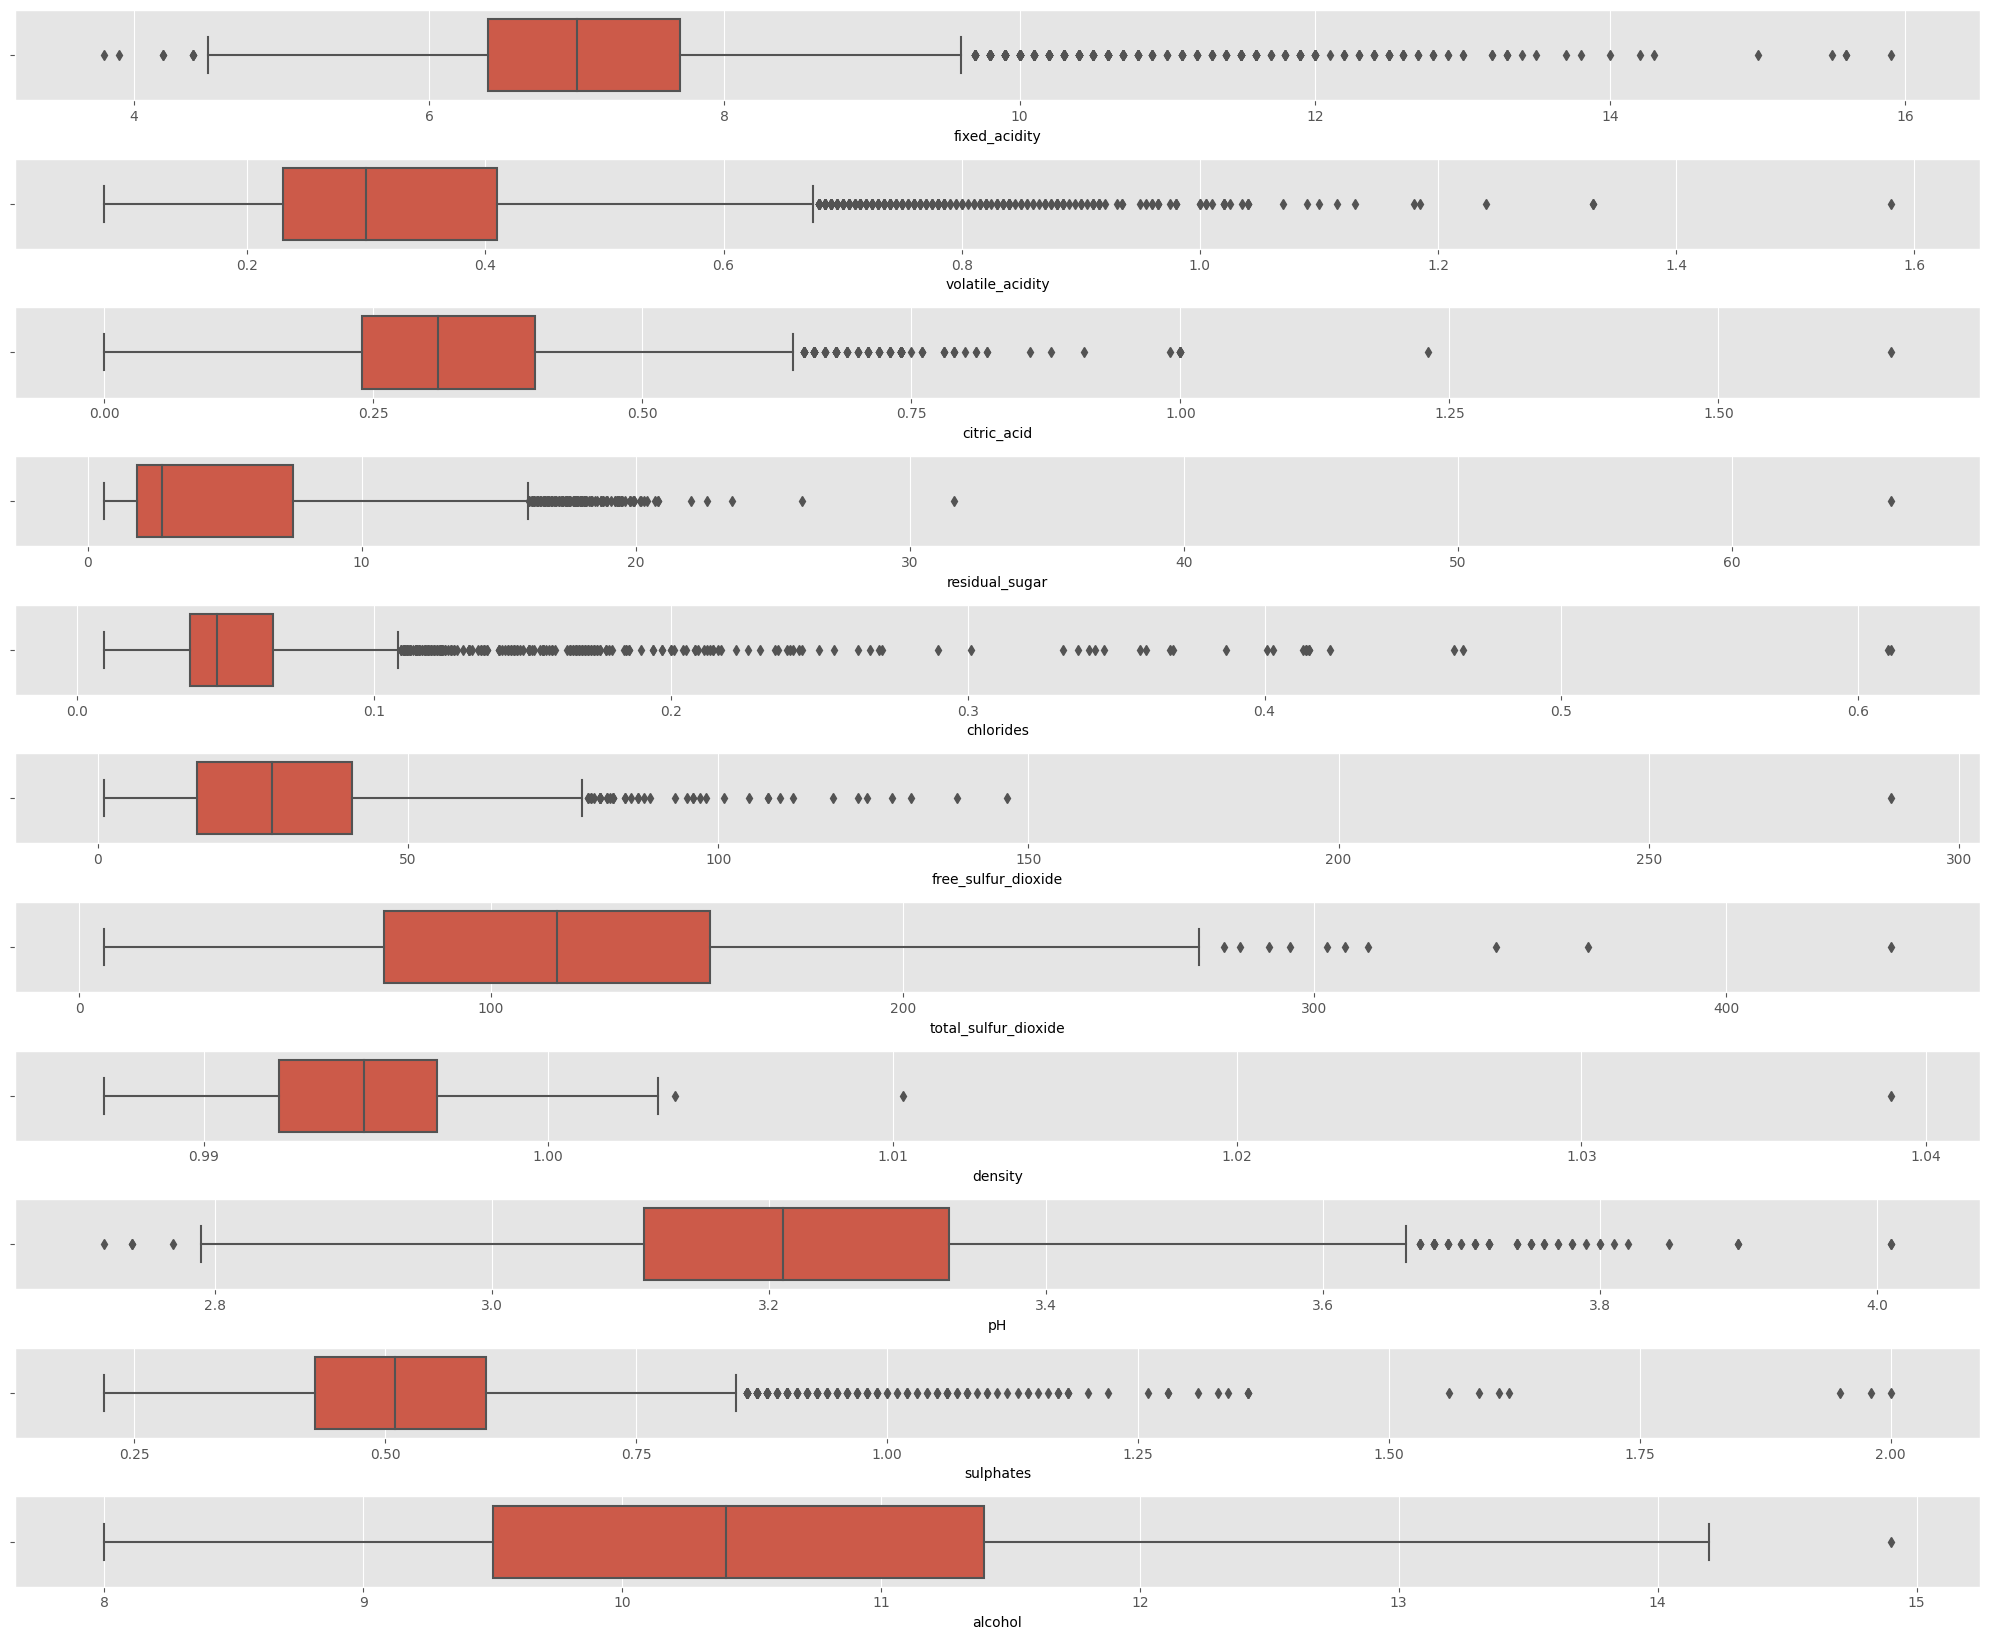

In [17]:
fig, axes = plt.subplots(11, 1, figsize=(20, 16.5), tight_layout=True)

for i, ax in enumerate(axes.flat):
    sns.boxplot(x=df[numeric_features[i]], ax=ax)

These boxplots tell me that there are some outliers in the data. I will need to decide if I want to keep these outliers or not.

<hr />

## Handling Outliers

For each of the fields, I decided to do some trail and error to find out what percentile of the data (top and bottom percentile) I want to replace with the median value of the column, keeping the percentile value change to a minimum so as to not impute too many fields, but also to remove as many outliers as possible. Here are the outcomes of my trail and erroring

In [18]:
trim_config: dict[str, tuple[int, int]] = {
    "fixed_acidity": (0.03, 0.92),
    "volatile_acidity": (0, 0.81),
    "citric_acid": (0.06, 0.95),
    "residual_sugar": (0, 0.93),
    "chlorides": (0, 0.92),
    "free_sulfur_dioxide": (0, 0.9),
    "total_sulfur_dioxide": (0, 0.95),
    "density": (0, 0.99),
    "pH": (0.01, 0.98),
    "sulphates": (0, 0.96),
    "alcohol": (0, 0.99),
    "quality": (0.01, 0.97)
}

for feature, iqr_range in trim_config.items():
    df[f"{feature}_trimmed"] = df[feature].clip(
        df[feature].quantile(iqr_range[0]),
        df[feature].quantile(iqr_range[1])
    )

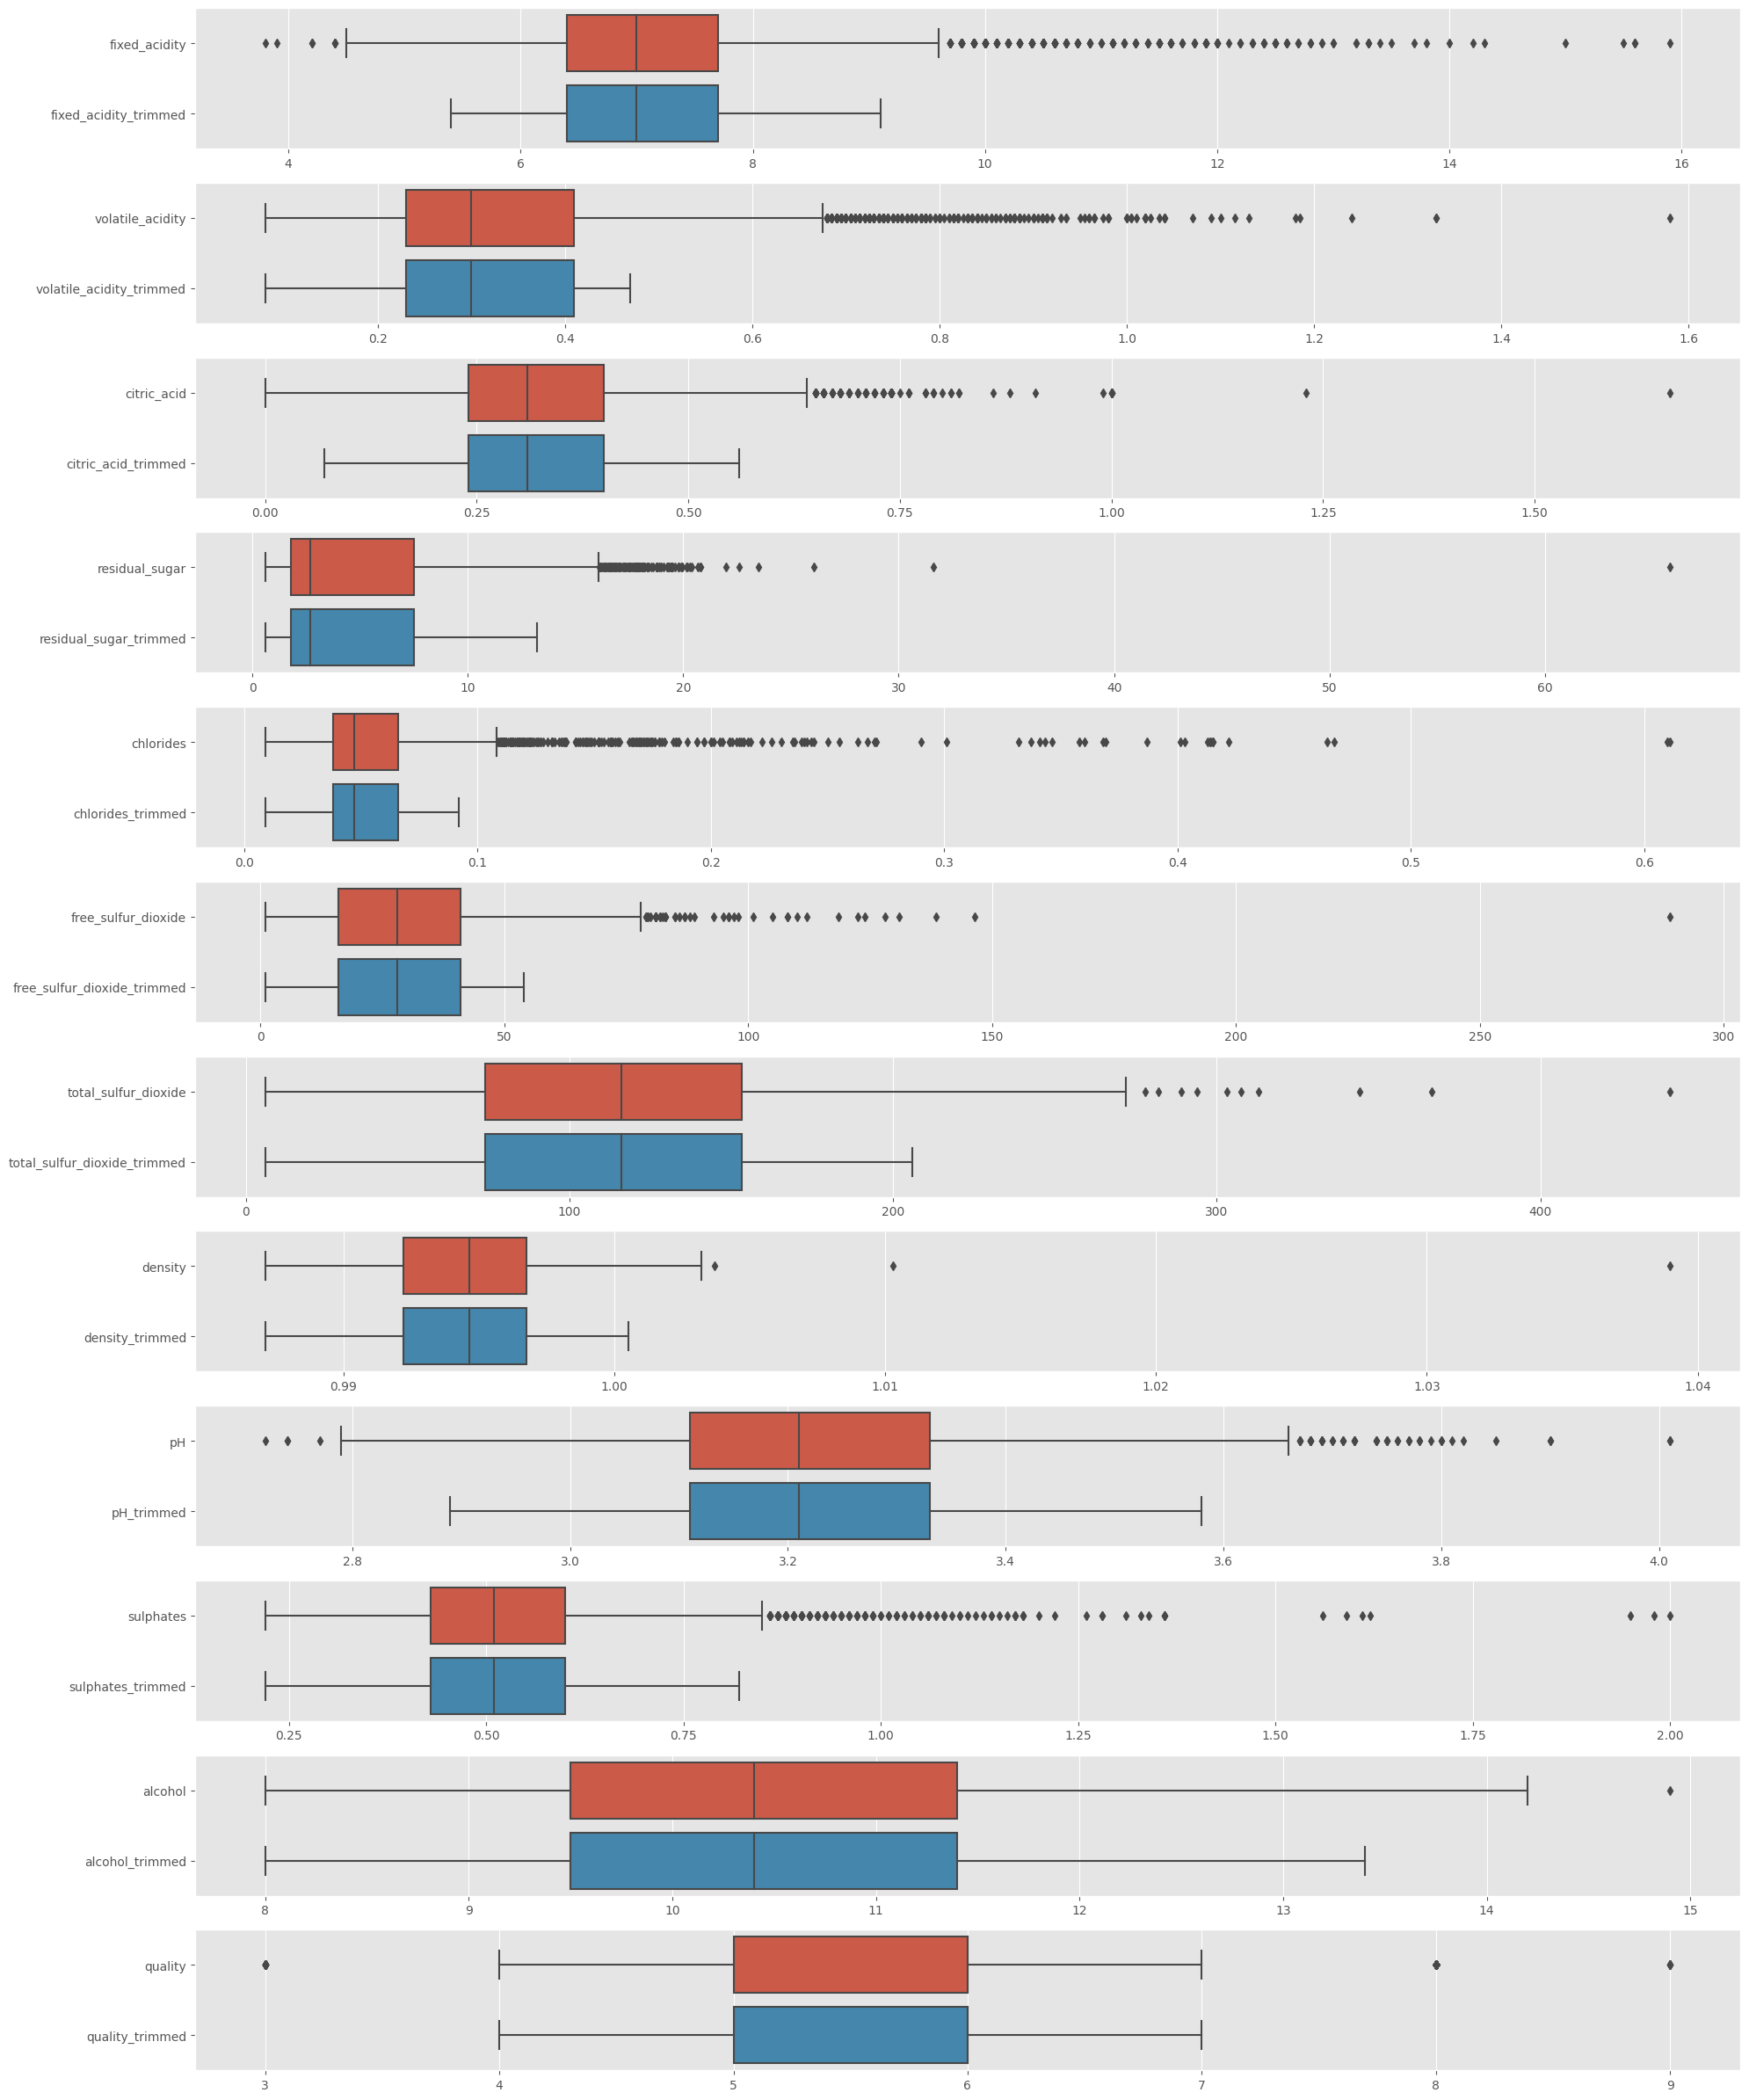

In [19]:
fig, axes = plt.subplots(12, 1, figsize=(20, 24), tight_layout=True)

for i, ax in enumerate(axes.flat):
    if i == 11:
        feature = "quality"
    else:
        feature = numeric_features[i]

    sns.boxplot(
        pd.melt(df[[feature, f"{feature}_trimmed"]]),
        x="value",
        y="variable",
        ax=ax
    ).set(
        xlabel=None,
        ylabel=None
    )

### Overwriting the original columns with the trimmed columns

In [20]:
for feature in numeric_features + ["quality"]:
    df[feature] = df[f"{feature}_trimmed"]
    df: pd.DataFrame = df.drop(columns=[f"{feature}_trimmed"])

## Correlation of each feature

<Axes: >

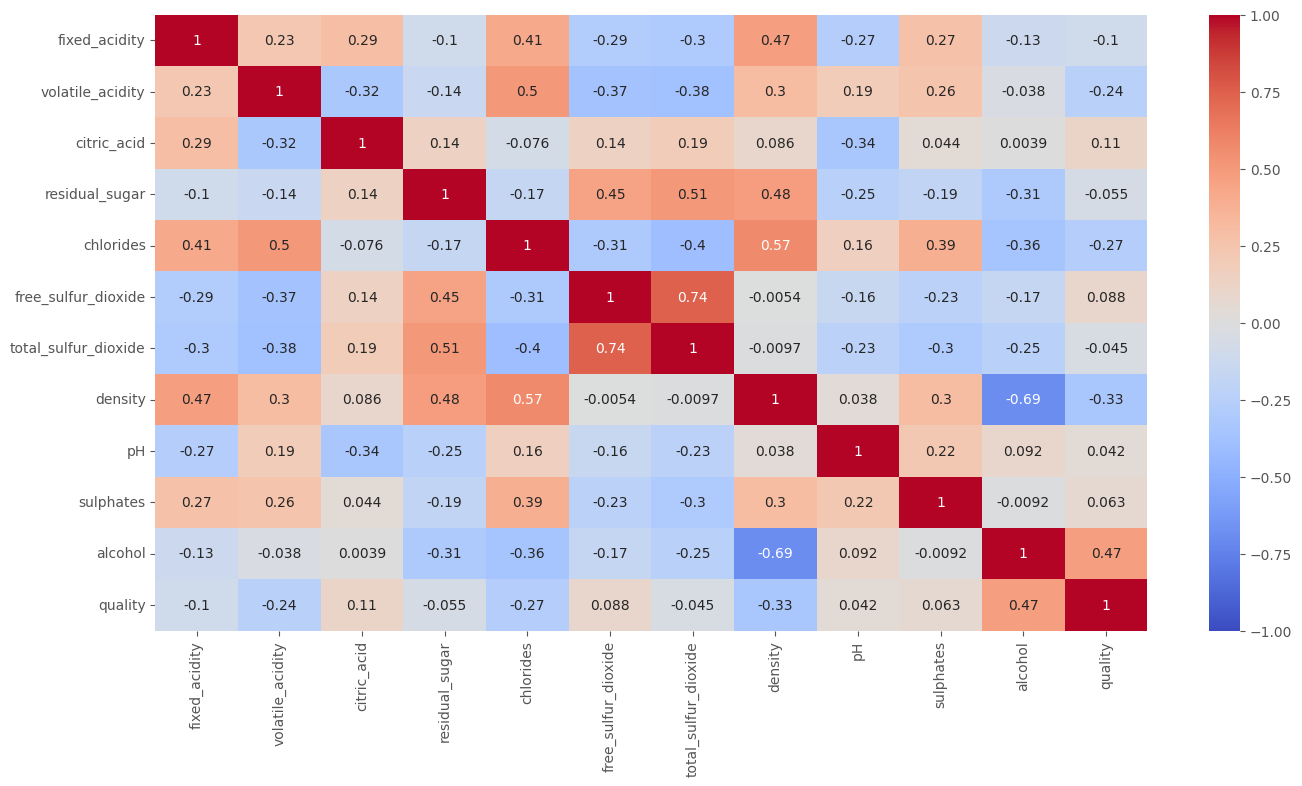

In [21]:
fig, ax = plt.subplots(figsize=(16, 8))

sns.heatmap(
    df[numeric_features + ["quality"]].corr(),
    vmin=-1,
    vmax=1,
    annot=True,
    cmap="coolwarm",
    ax=ax,
)

This correlation heatmap tells me that the features have a moderate correlation with each other. This means that I will need to do some feature selection to reduce the number of features I use in my model.

<hr />

## Correlation of each feature with the target

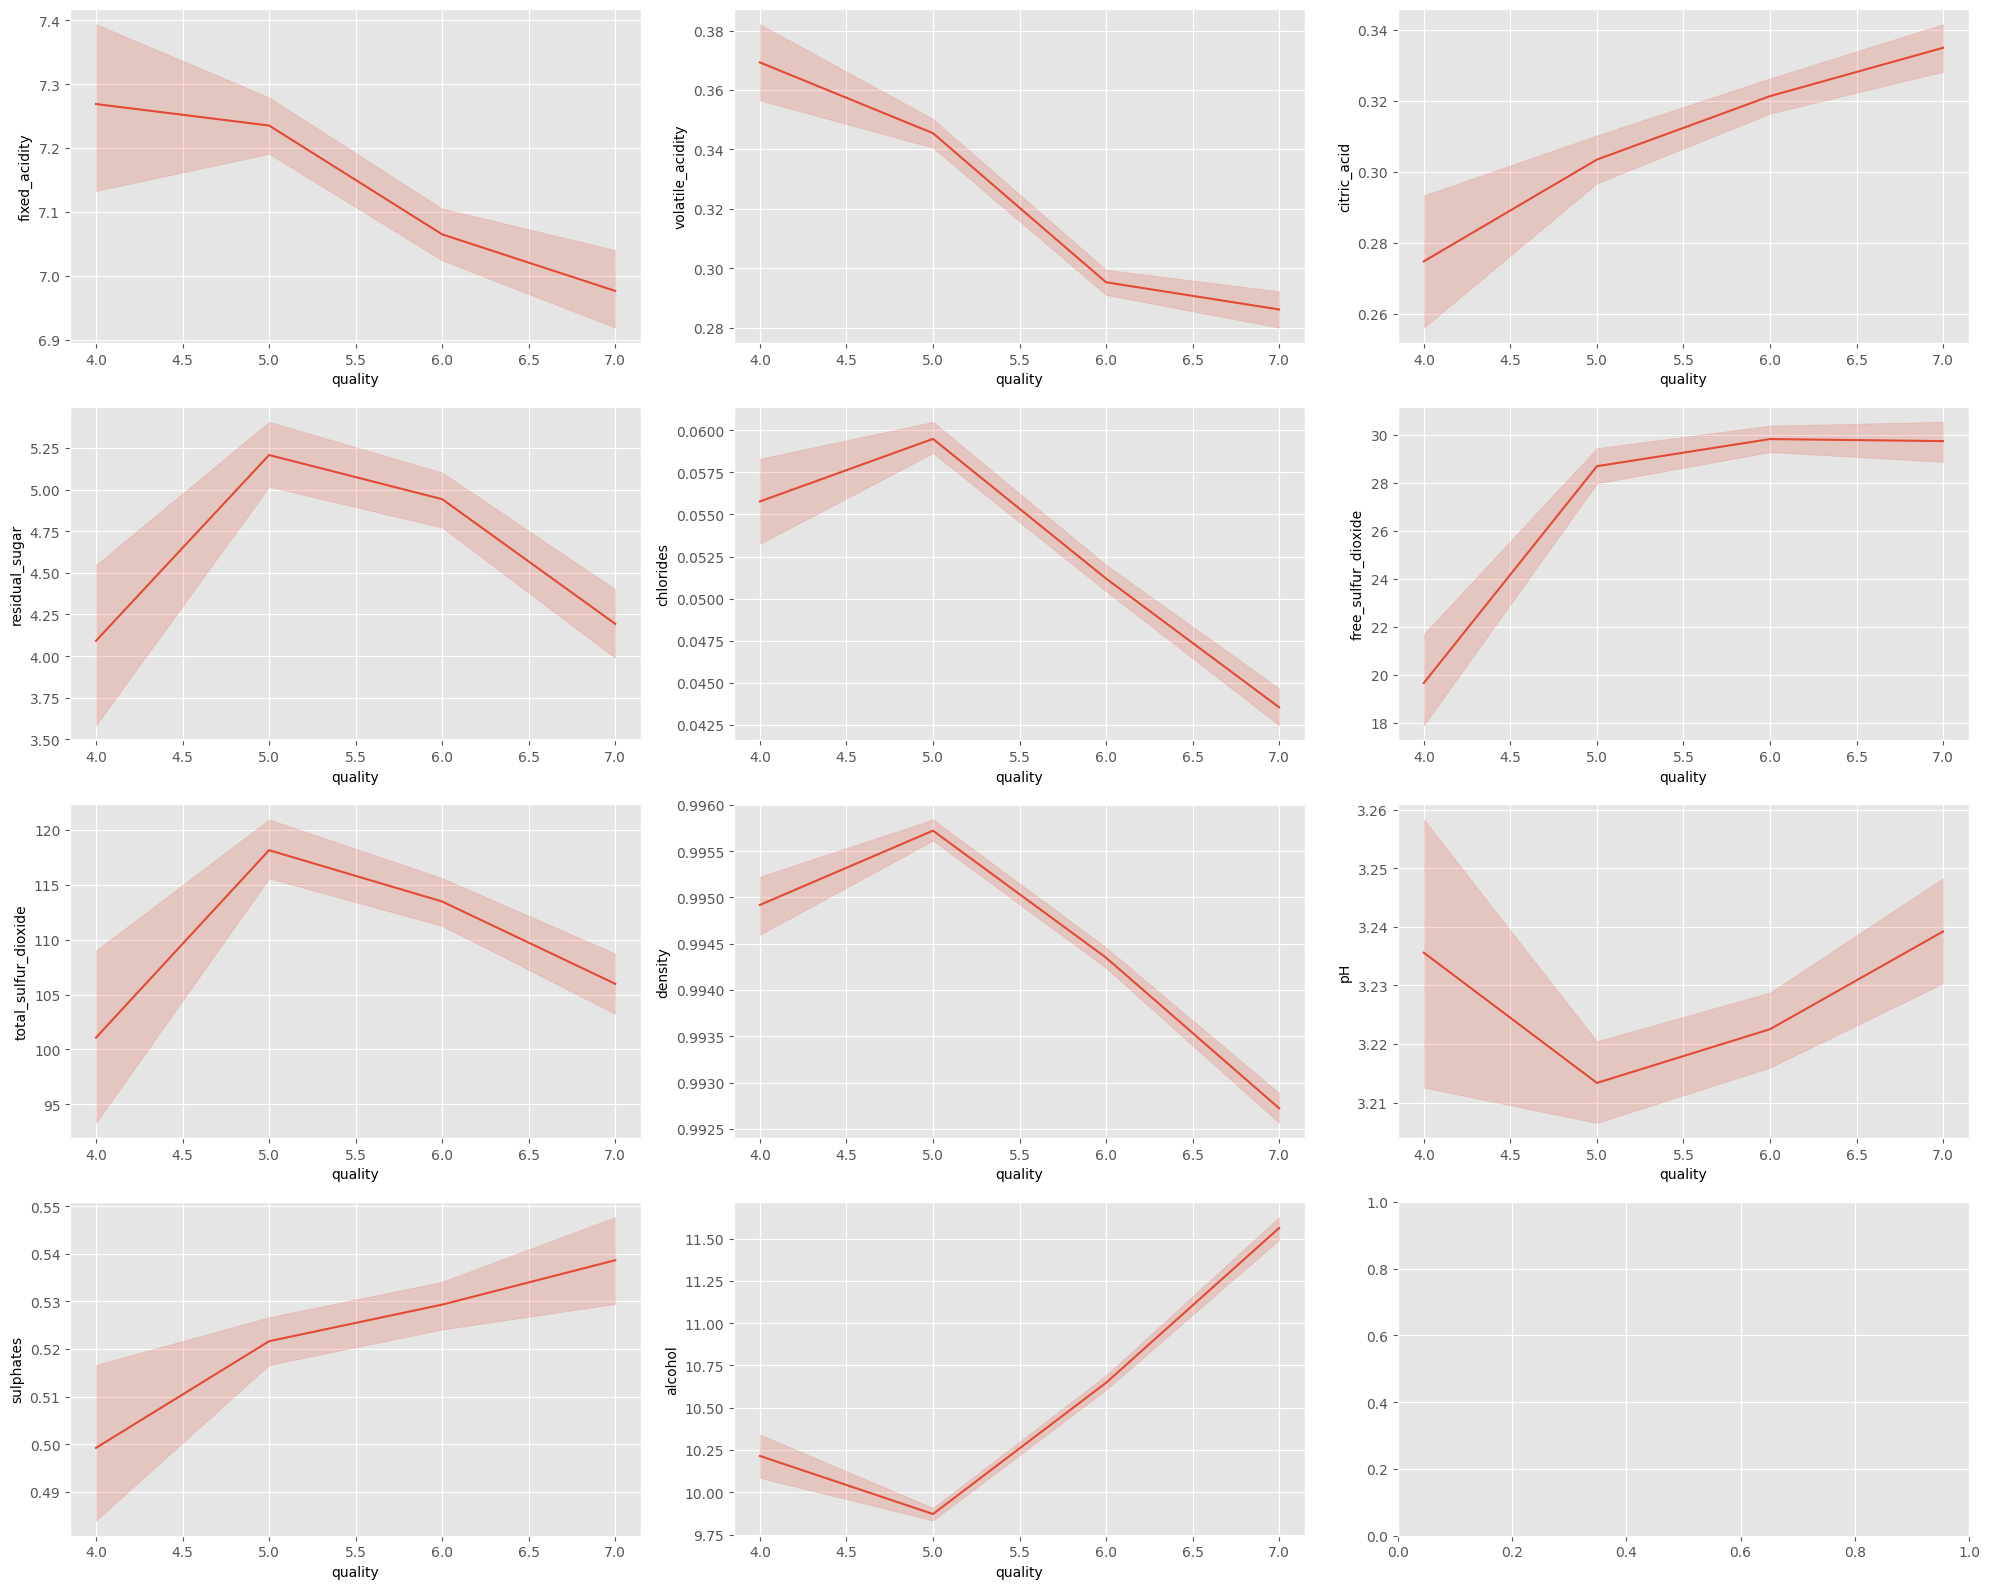

In [22]:
fig, axes = plt.subplots(4, 3, figsize=(20, 16), tight_layout=True)

for i, ax in enumerate(axes.flat):
    if i == 11: break
    sns.lineplot(df, x="quality", y=numeric_features[i], ax=ax)

These graphs tell me that some of the features are more likely to affect the quality of the wine than others since the lines are more linear than the others, and can be used to predict the quality of the wine better. 

<hr />

# Feature Engineering & Model Building

## Normally Distributing the Data

I decided to transform each column individually so that they aren't skewed to either direction. I will be applying these changes to the data frame directly but rather by doing it in the pipeline

In [23]:
boxcox_transformer = PowerTransformer(method="box-cox")

Here I am plotting the before and after boxcox transformation for each numeric feature

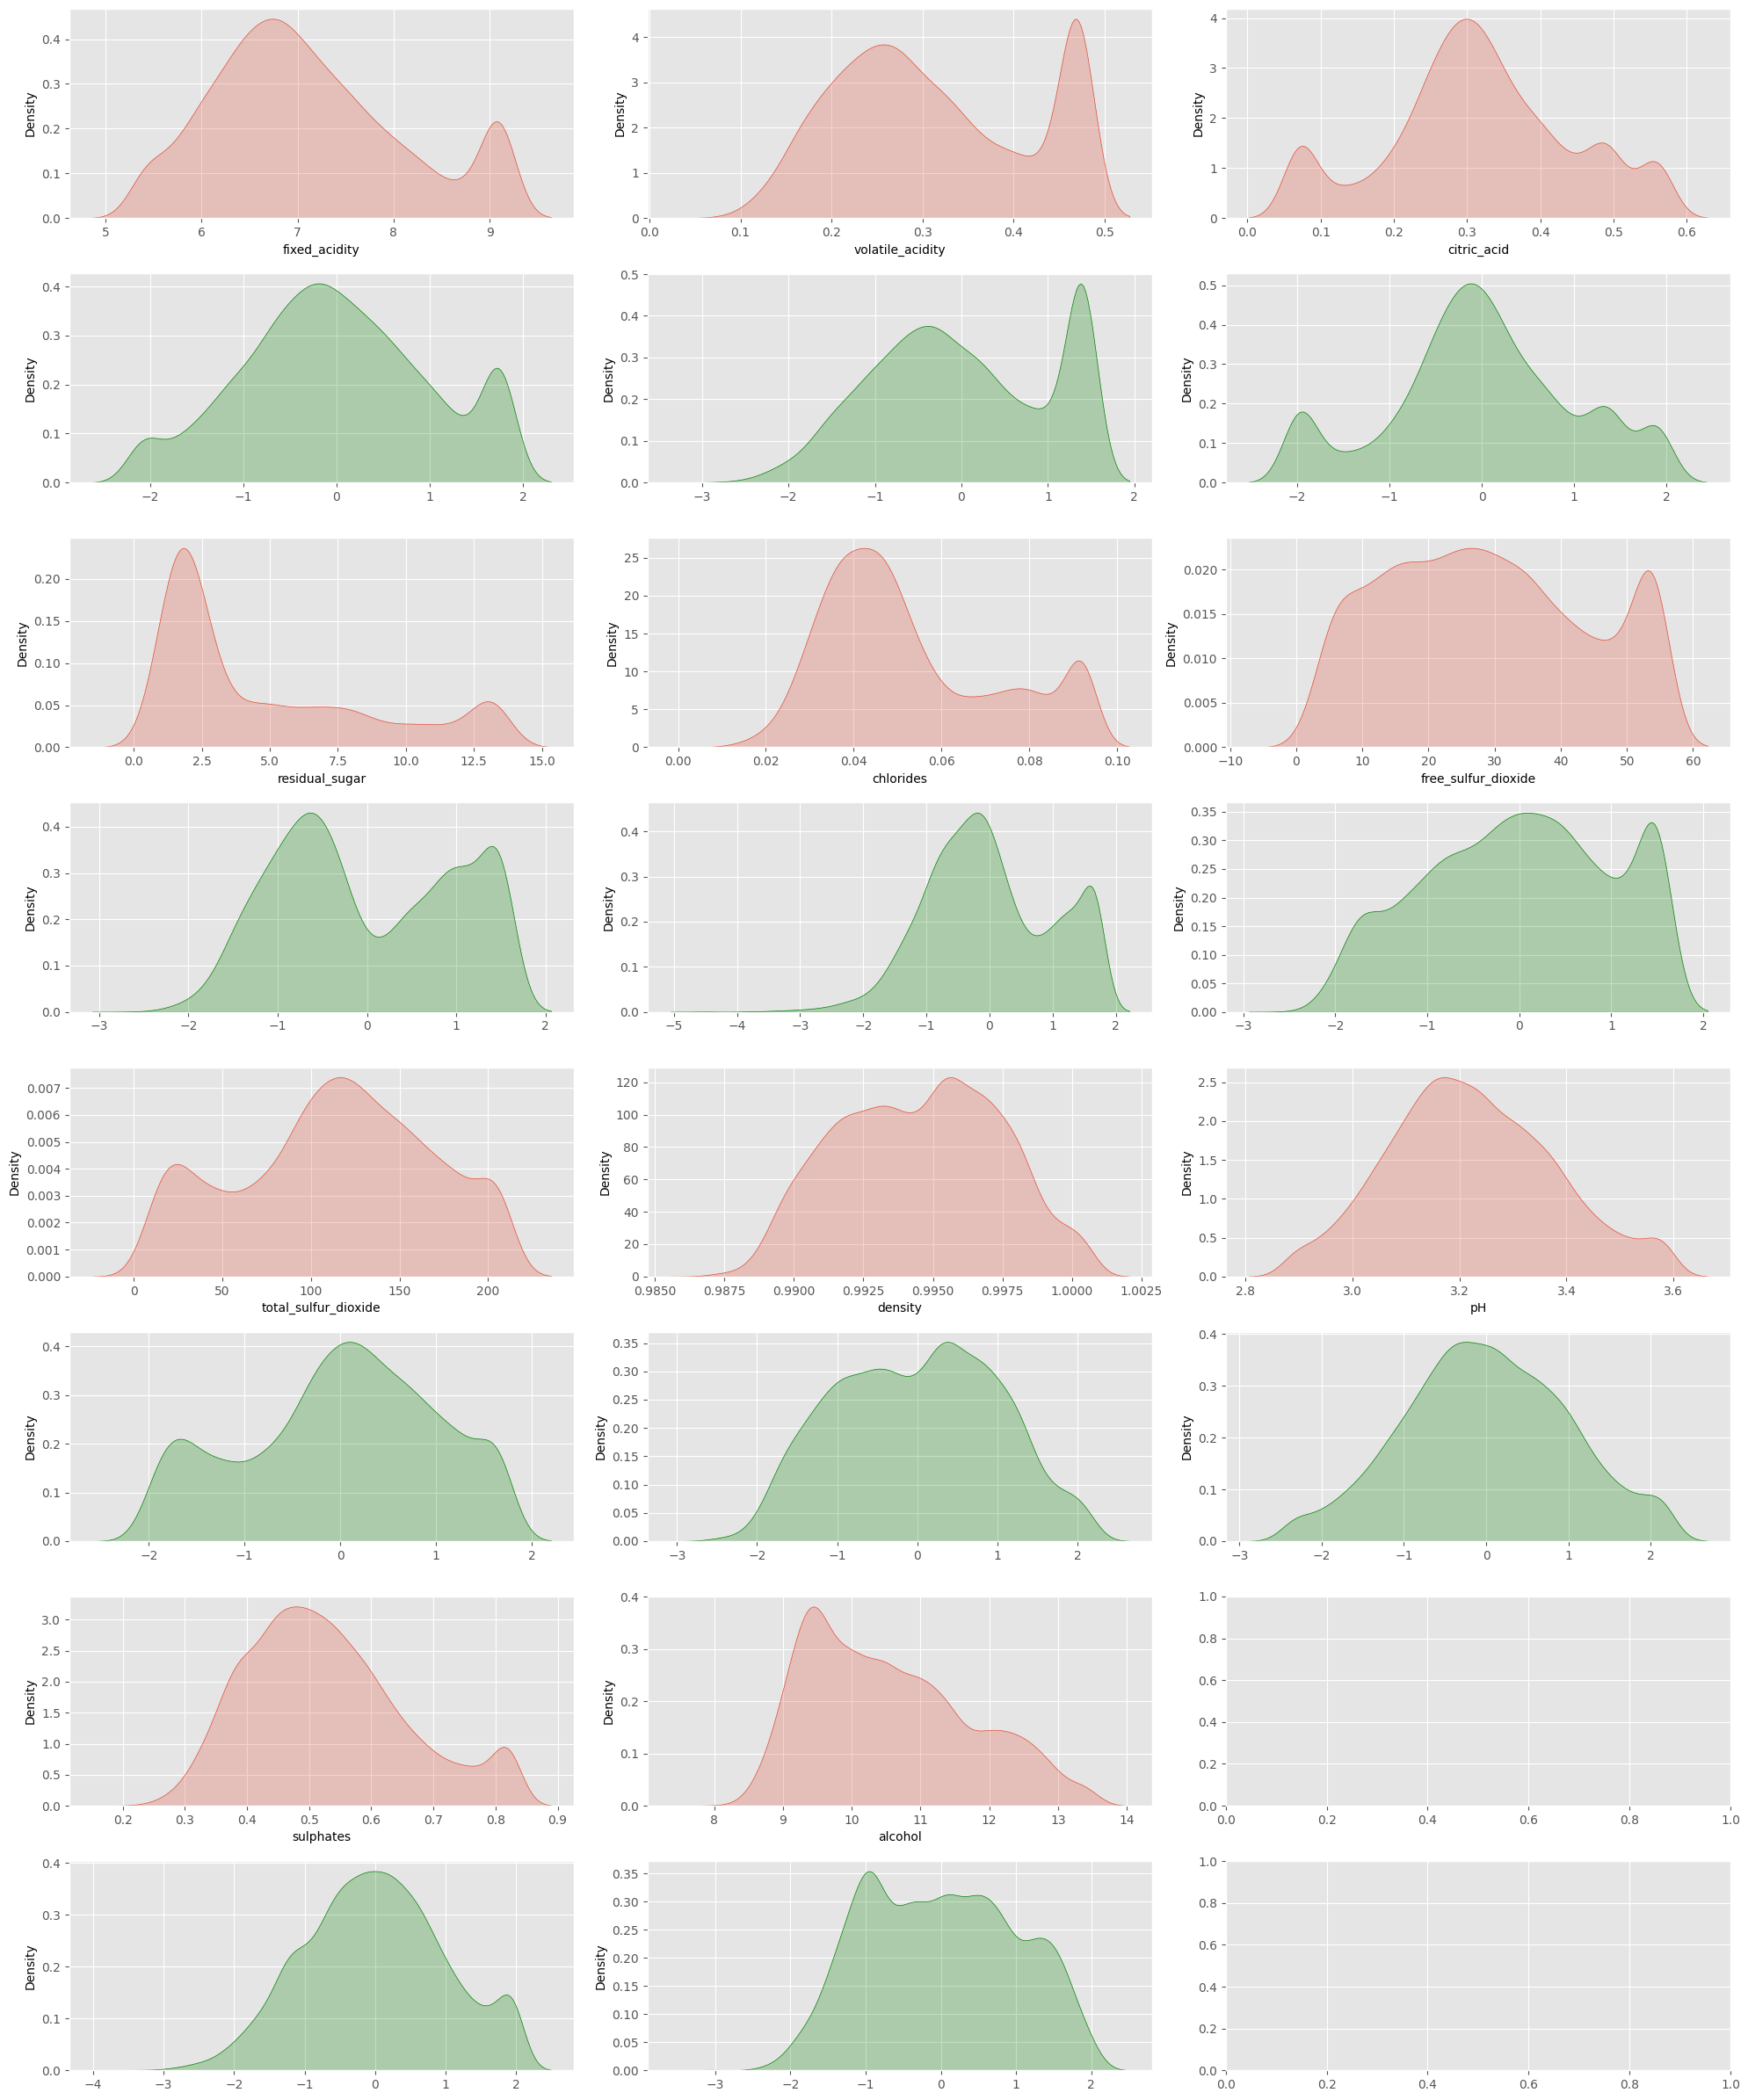

In [24]:
fig, axes = plt.subplots(8, 3, figsize=(20, 24), tight_layout=True)

for i, ax in enumerate(axes.flat):
    if i in [20, 23]: continue

    # some magic to get the right feature name
    feature = numeric_features[i - ((i % 6 > 2) + i // 6) * 3]
    if i % 6 > 2:
        data = PowerTransformer(method="box-cox").fit_transform(df[[feature]])
        data.shape = (data.shape[0],)
        sns.kdeplot(data, fill=True, color="green", ax=ax)
    else:
        sns.kdeplot(df[feature], fill=True, ax=ax)

## Normalizing the data

I am using a pipeline with a standard scaler to normalize my numeric columns

In [25]:
normalizing_transformer = MinMaxScaler()

## One Hot Encoding

I am using a pipeline with a one hot encoder to one hot encode the categorical features

In [26]:
onehot_transformer = OneHotEncoder(handle_unknown="ignore")

## Classifying the target

I decided to split the output into 3 classes, 1 for low quality, 1 for medium quality, and 1 for high quality. This is because my output variable is not exactly continuous (since the value is either 3, 4, 5, 6, 7, 8 or 9). However if I use regression to solve this, I will have to use a continuous output variable, so I decided to use classification instead.

<Axes: xlabel='quality', ylabel='Count'>

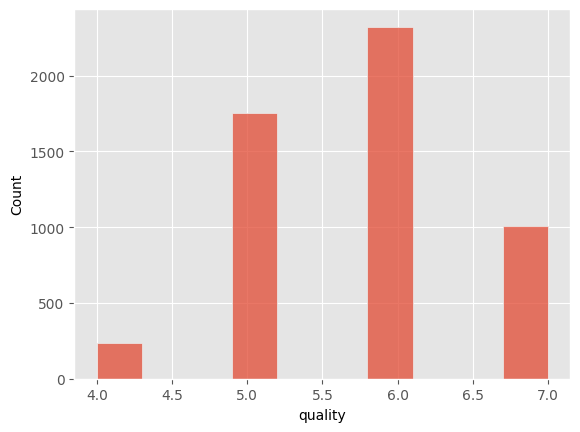

In [27]:
sns.histplot(df["quality"], bins=10)

From the above histogram we can roughly split the data into 3 classes, 1 for low quality, 1 for medium quality, and 1 for high quality. I will use this to classify the data.

In [28]:
df["quality_class"] = np.where(df["quality"] <= 4, "low", np.where(df["quality"] >= 7, "high", "medium"))

<Axes: xlabel='quality_class', ylabel='Count'>

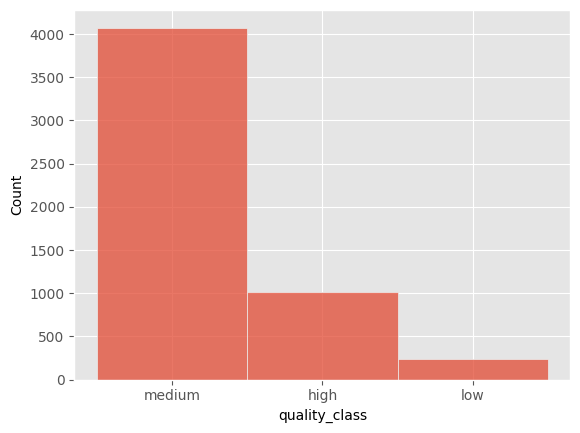

In [29]:
sns.histplot(df["quality_class"])

In [30]:
df = df.drop(columns=["quality"])

## Choosing the right Model

I need to find which model would run my code best, so I decided to run a few different classifiers with default parameters to see which gives me the best model score

In [84]:
transformer = ColumnTransformer([
    ("numeric", Pipeline([
        ("boxcox", boxcox_transformer),
        ("normalizer", normalizing_transformer),
    ]), df[numeric_features].columns),
    ("categorical", Pipeline([
        ("onehot", onehot_transformer)
    ]), df[categorical_features].columns)
])

In [85]:
X = df.drop(columns=["quality_class"])
y = df["quality_class"]

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=hash("2100326D") % 2 ** 32)
X_train: pd.DataFrame
X_test: pd.DataFrame
y_train: pd.Series
y_test: pd.Series

In [86]:
models_df = pd.DataFrame(columns=["model", "accuracy"])

In [87]:
gbc_pipeline = Pipeline([
    ("transformer", transformer),
    ("classifier", GradientBoostingClassifier(random_state=0))
])
gbc_pipeline.fit(X_train, y_train)

print("GradientBoostingClassifier Accuracy: %.4f" % accuracy_score(y_test, gbc_pipeline.predict(X_test)))
models_df = models_df.append({
    "model": "GradientBoostingClassifier",
    "accuracy": accuracy_score(y_test, gbc_pipeline.predict(X_test))
}, ignore_index=True)

GradientBoostingClassifier Accuracy: 0.7934


In [88]:
svc_pipeline = Pipeline([
    ("transformer", transformer),
    ("classifier", SVC(random_state=0))
])
svc_pipeline.fit(X_train, y_train)

print("SVC Accuracy: %.4f" % accuracy_score(y_test, svc_pipeline.predict(X_test)))
models_df = models_df.append({
    "model": "SVC",
    "accuracy": accuracy_score(y_test, svc_pipeline.predict(X_test))
}, ignore_index=True)

SVC Accuracy: 0.7890


In [89]:
rfc_pipelin = Pipeline([
    ("transformer", transformer),
    ("classifier", RandomForestClassifier(random_state=0))
])
rfc_pipelin.fit(X_train, y_train)

print("RandomForestClassifier Accuracy: %.4f" % accuracy_score(y_test, rfc_pipelin.predict(X_test)))
models_df = models_df.append({
    "model": "RandomForestClassifier",
    "accuracy": accuracy_score(y_test, rfc_pipelin.predict(X_test))
}, ignore_index=True)

RandomForestClassifier Accuracy: 0.7959


In [90]:
knc_pipeline = Pipeline([
    ("transformer", transformer),
    ("classifier", KNeighborsClassifier())
])
knc_pipeline.fit(X_train, y_train)

print("KNeighborsClassifier Accuracy: %.4f" % accuracy_score(y_test, knc_pipeline.predict(X_test)))
models_df = models_df.append({
    "model": "KNeighborsClassifier",
    "accuracy": accuracy_score(y_test, knc_pipeline.predict(X_test))
}, ignore_index=True)

KNeighborsClassifier Accuracy: 0.7790


In [91]:
dtc_pipeline = Pipeline([
    ("transformer", transformer),
    ("classifier", DecisionTreeClassifier(random_state=0))
])
dtc_pipeline.fit(X_train, y_train)

print("DecisionTreeClassifier Accuracy: %.4f" % accuracy_score(y_test, dtc_pipeline.predict(X_test)))
models_df = models_df.append({
    "model": "DecisionTreeClassifier",
    "accuracy": accuracy_score(y_test, dtc_pipeline.predict(X_test))
}, ignore_index=True)

DecisionTreeClassifier Accuracy: 0.7032


<Axes: xlabel='accuracy', ylabel='model'>

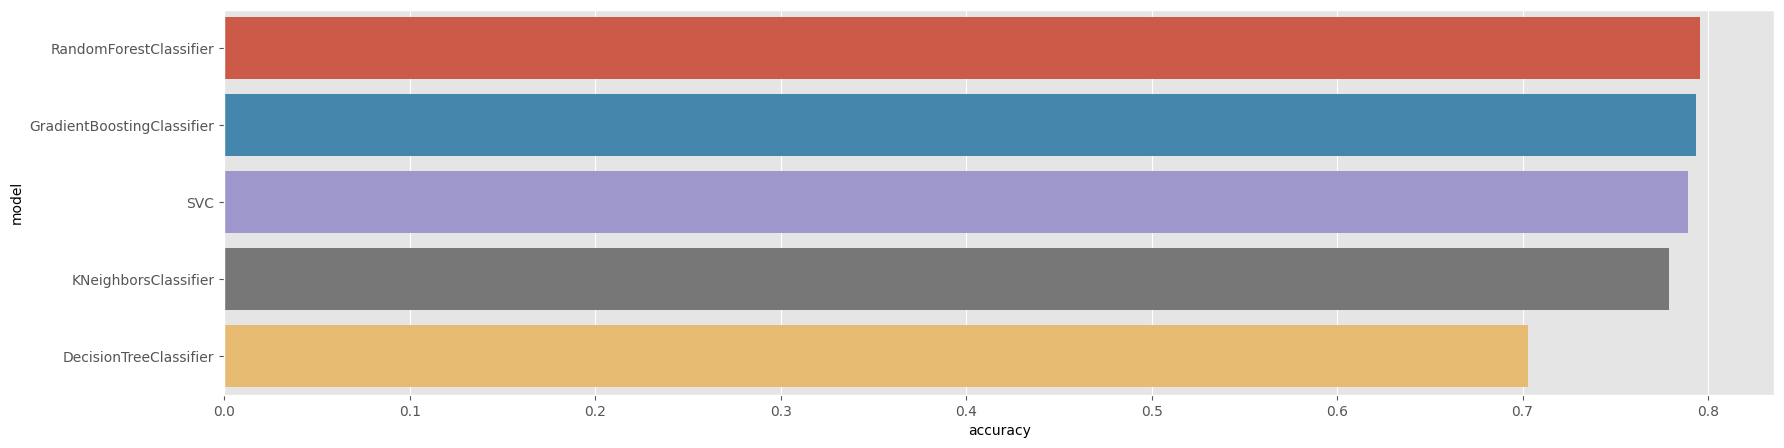

In [92]:
fig, ax = plt.subplots(figsize=(20, 5))

sns.barplot(
    data=models_df.sort_values(by="accuracy", ascending=False),
    x="accuracy",
    y="model",
    ax=ax
)

From this we can see the best classifier is the RandomForestClassifier, so I will use that for my model

## First Draft of Model

I need to have at least one draft of the model before I can decide which features to keep, remove and scale for Feature Engineering. Becuase of this, I will run a simple RandomForestClassifier model with BayesSearchCV to find the best parameters for the model.

In [27]:
running_bayes = False

The parameters here were found through a previous search, in the cases where I don't want to run bayes again since it can be very time consuming during testing

In [28]:
bayes_optimal = {
    "max_depth": 3705,
    "min_samples_leaf": 1,
    "min_samples_split": 2,
    "n_estimators": 238
}

In [29]:
rfc_pipeline = Pipeline([
    ("transformer", transformer),
    ("classifier", RandomForestClassifier(
        **({} if running_bayes else bayes_optimal),
        random_state=hash("2100326D") % 2 ** 32,
        n_jobs=-1
    ))
])

Now depending on whether I've run BayesSearchCV, I will either load the best parameters found or calculate them again

In [31]:
if running_bayes:
    # Fix a bug in scikit-optimize
    np.int = int

    bs = BayesSearchCV(
        rfc_pipeline,
        {
            "classifier__max_depth": (1, 10000),
            "classifier__min_samples_leaf": (1, 5),
            "classifier__min_samples_split": (2, 5),
            "classifier__n_estimators": (1, 1000)
        },
        n_iter=100,
        scoring="accuracy",
        cv=5,
        n_jobs=-1,
        verbose=2
    )

    bs.fit(X_train, y_train)
    bayes_optimal = {
        "max_depth": bs.best_params_["classifier__max_depth"],
        "min_samples_leaf": bs.best_params_["classifier__min_samples_leaf"],
        "min_samples_split": bs.best_params_["classifier__min_samples_split"],
        "n_estimators": bs.best_params_["classifier__n_estimators"]
    }

    print("Best params:", bayes_optimal)
    print("Accuracy Score: %.4f" % accuracy_score(y_test, bs.predict(X_test)))
else:
    rfc_pipeline.fit(X_train, y_train)

    print("Accuracy Score: %.4f" % accuracy_score(y_test, rfc_pipeline.predict(X_test)))

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END classifier__max_depth=7311, classifier__min_samples_leaf=5, classifier__min_samples_split=2, classifier__n_estimators=133; total time=   0.4s
[CV] END classifier__max_depth=7311, classifier__min_samples_leaf=5, classifier__min_samples_split=2, classifier__n_estimators=133; total time=   0.4s
[CV] END classifier__max_depth=7311, classifier__min_samples_leaf=5, classifier__min_samples_split=2, classifier__n_estimators=133; total time=   0.4s
[CV] END classifier__max_depth=7311, classifier__min_samples_leaf=5, classifier__min_samples_split=2, classifier__n_estimators=133; total time=   0.4s
[CV] END classifier__max_depth=7311, classifier__min_samples_leaf=5, classifier__min_samples_split=2, classifier__n_estimators=133; total time=   0.4s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END classifier__max_depth=7916, classifier__min_samples_leaf=4, classifier__min_samples_split=4, classifier__n_estimators=

<AxesSubplot: xlabel='Importance'>

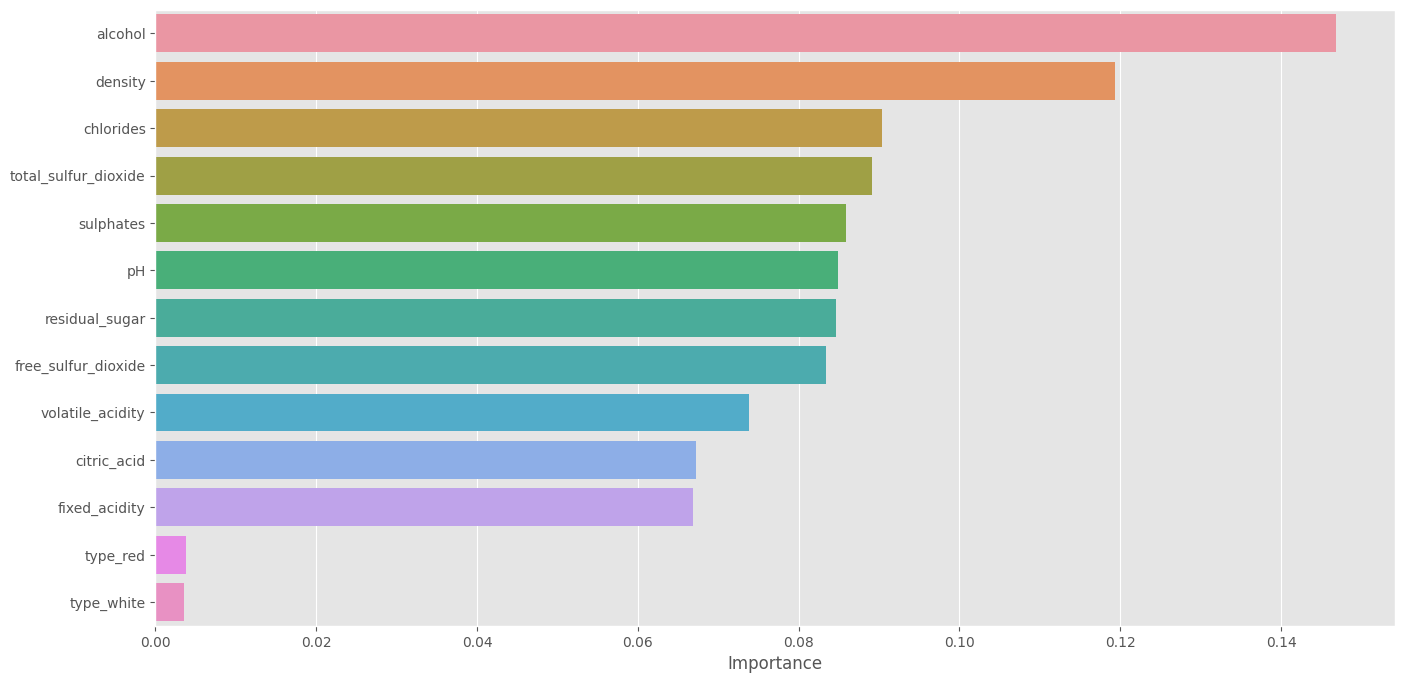

In [32]:
fig, ax = plt.subplots(figsize=(16, 8))

rfc_pipeline: Pipeline = bs.best_estimator_ if running_bayes else rfc_pipeline
_classifier: RandomForestClassifier = rfc_pipeline.named_steps.classifier
_onehot: OneHotEncoder = rfc_pipeline.named_steps.transformer.named_transformers_.categorical.named_steps.onehot

importances = pd.DataFrame(
    _classifier.feature_importances_,
    index=list(X_train.drop(columns=["type"]).columns) + list(_onehot.get_feature_names_out()),
    columns=["Importance"]
).sort_values(by="Importance", ascending=True).T

sns.barplot(
    data=importances.T[::-1],
    x="Importance",
    y=importances.columns[::-1],
    ax=ax
)

## Feature Selection

Before I do feature selection, here is a reusable function to fit the model and return it's scores. It modifies the pipelines to work when some columns are missing

In [33]:
def fit_with_features(features: list[str]) -> int:
    rfc_pipeline = Pipeline([
        ("transformer", ColumnTransformer([
            ("numeric", Pipeline([
                ("boxcox", boxcox_transformer),
                ("normalizer", normalizing_transformer),
            ]), df[[feature for feature in features if feature != "type"]].columns),
            ("categorical", Pipeline([
                ("onehot", onehot_transformer)
            ]), df[df[["type"] if "type" in features else []].columns].columns)
        ])),
        ("classifier", RandomForestClassifier(
            **bayes_optimal,
            random_state=hash("2100326D") % 2 ** 32,
            n_jobs=-1
        ))
    ])
    
    rfc_pipeline.fit(X_train[features], y_train)

    return accuracy_score(y_test, rfc_pipeline.predict(X_test[features]))

I'm going to run fit the model with all possible combination of the feature list to find which combination gives me the best score for the model.

In [34]:
running_combinations = False

These values are the optimal values found in the previous run of this notebook.

In [35]:
combinations_optimal = ['fixed_acidity', 'volatile_acidity', 'citric_acid', 'residual_sugar', 'free_sulfur_dioxide', 'density', 'pH', 'sulphates', 'alcohol', 'type']
score_optimal = 0

Now depending on whether I've run the combinations already, I will either load the previous data or calculate it again

In [36]:
mixed_features = numeric_features + categorical_features

if running_combinations:
    count = 0
    total = len([combination for i in range(1, len(mixed_features)) for combination in itertools.combinations(mixed_features, i)])

    for i in range(1, len(mixed_features)):
        for features in itertools.combinations(mixed_features, i):
            features = list(features)

            score = fit_with_features(features)
            count += 1
            print(f"{count} out of {total}")
            print("Accuracy score: %.4f" % score)

            if score > score_optimal:
                print("Highscore!")
                combinations_optimal = features
                score_optimal = score

            print()
    print()
else:
    score_optimal = fit_with_features(combinations_optimal)

print(f"With: {combinations_optimal}")
print(f"Without: {[feature for feature in mixed_features if feature not in combinations_optimal]}")
print("Accuracy score: %.4f" % score_optimal)

1 out of 4094
Accuracy score: 0.7677
Highscore!

2 out of 4094
Accuracy score: 0.7664

3 out of 4094
Accuracy score: 0.7677

4 out of 4094
Accuracy score: 0.7689
Highscore!

5 out of 4094
Accuracy score: 0.7646

6 out of 4094
Accuracy score: 0.7683

7 out of 4094
Accuracy score: 0.7677

8 out of 4094
Accuracy score: 0.7295

9 out of 4094
Accuracy score: 0.7677

10 out of 4094
Accuracy score: 0.7621

11 out of 4094
Accuracy score: 0.7683

12 out of 4094
Accuracy score: 0.7677

13 out of 4094
Accuracy score: 0.7301

14 out of 4094
Accuracy score: 0.6994

15 out of 4094
Accuracy score: 0.7013

16 out of 4094
Accuracy score: 0.7151

17 out of 4094
Accuracy score: 0.6944

18 out of 4094
Accuracy score: 0.6963

19 out of 4094
Accuracy score: 0.7201

20 out of 4094
Accuracy score: 0.7188

21 out of 4094
Accuracy score: 0.7195

22 out of 4094
Accuracy score: 0.7364

23 out of 4094
Accuracy score: 0.7671

24 out of 4094
Accuracy score: 0.7126

25 out of 4094
Accuracy score: 0.7070

26 out of 40

In [37]:
numeric_features = [feature for feature in numeric_features if feature in combinations_optimal]
categorical_features = [feature for feature in categorical_features if feature in combinations_optimal]

X_train = X_train[combinations_optimal]
X_test = X_test[combinations_optimal]

## Final Model

Now that I am done with Feature Engineering, I can build the final version of the model. I will also run bayes again to find the best parameters for my model since my dataset changed a bit.

In [38]:
running_bayes = False

The parameters here were found through a previous search, in the cases where I don't want to run bayes again since it can be very time consuming during testing

In [39]:
bayes_optimal = {
    "max_depth": 4993,
    "min_samples_leaf": 1,
    "min_samples_split": 3,
    "n_estimators": 602
}

In [40]:
rfc_pipeline = Pipeline([
    ("transformer", ColumnTransformer([
        ("numeric", Pipeline([
            ("boxcox", boxcox_transformer),
            ("normalizer", normalizing_transformer),
        ]), df[numeric_features].columns),
        ("categorical", Pipeline([
            ("onehot", onehot_transformer)
        ]), df[categorical_features].columns)
    ])),
    ("classifier", RandomForestClassifier(
        **({} if running_bayes else bayes_optimal),
        random_state=hash("2100326D") % 2 ** 32,
        n_jobs=-1
    ))
])

Now depending on whether I've run BayesSearchCV already, I will either load the best parameters found or calculate them again

In [41]:
if running_bayes:
    # Fix a bug in scikit-optimize
    np.int = int

    bs = BayesSearchCV(
        rfc_pipeline,
        {
            "classifier__max_depth": (1, 10000),
            "classifier__min_samples_leaf": (1, 5),
            "classifier__min_samples_split": (2, 5),
            "classifier__n_estimators": (1, 1000)
        },
        n_iter=100,
        scoring="accuracy",
        cv=5,
        n_jobs=-1,
        verbose=2
    )

    bs.fit(X_train, y_train)
    bayes_optimal = {
        "max_depth": bs.best_params_["classifier__max_depth"],
        "min_samples_leaf": bs.best_params_["classifier__min_samples_leaf"],
        "min_samples_split": bs.best_params_["classifier__min_samples_split"],
        "n_estimators": bs.best_params_["classifier__n_estimators"]
    }

    print("Best params:", bayes_optimal)
    print("Accuracy Score: %.4f" % accuracy_score(y_test, bs.predict(X_test)))
else:
    rfc_pipeline.fit(X_train, y_train)

    print("Accuracy Score: %.4f" % accuracy_score(y_test, rfc_pipeline.predict(X_test)))

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END classifier__max_depth=3268, classifier__min_samples_leaf=5, classifier__min_samples_split=3, classifier__n_estimators=982; total time=   2.1s
[CV] END classifier__max_depth=3268, classifier__min_samples_leaf=5, classifier__min_samples_split=3, classifier__n_estimators=982; total time=   2.3s
[CV] END classifier__max_depth=3268, classifier__min_samples_leaf=5, classifier__min_samples_split=3, classifier__n_estimators=982; total time=   2.3s
[CV] END classifier__max_depth=3268, classifier__min_samples_leaf=5, classifier__min_samples_split=3, classifier__n_estimators=982; total time=   2.3s
[CV] END classifier__max_depth=3268, classifier__min_samples_leaf=5, classifier__min_samples_split=3, classifier__n_estimators=982; total time=   2.4s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END classifier__max_depth=908, classifier__min_samples_leaf=2, classifier__min_samples_split=3, classifier__n_estimators=5

# Exporting the Random Forest Classifier Pipeline

In [42]:
joblib.dump(bs.best_estimator_ if running_bayes else rfc_pipeline, "model.pkl")

['model.pkl']